## Overview

This notebook is a first part of full **Offline Handwritten Text Recognition**.     
See full system on Github: https://github.com/IrinaArmstrong/HandwrittenTextRecognition

**Offline Handwritten Text Recognition (HTR)** systems transcribe text contained in scanned images into digital text.             
In this case, the system is developed to deal with cyrillic alphabet. It also involves full dictionary of the Russian language.

In general, developed HTR consists of several parts, which are responsible for processing pages with full text (scanned or photographed), dividing them into lines, splitting the resulting lines into words and following recognition of words from them.

For solve the problem of recognition, it was decided to use Neural Network (NN). It consists of convolutional NN (CNN) layers, recurrent NN (RNN) layers and a final Connectionist Temporal Classification (CTC) layer.

But in this notebook only the task of page segmentation is highlighted. It was decided to do this in several different ways shown below.

### Imports

In [5]:
import cv2
import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

import os
print(os.listdir("./images"))
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize' : (22, 10)})
sns.set_style("darkgrid", {'axes.grid' : True})

['1.jpg', '2.jpg', '3.jpg', '4.jpg']


In [6]:
def showImg(img, cmap=None):
    plt.imshow(img, cmap=cmap, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

# Method #1.    
Implementation of scale space technique for word segmentation as proposed by R. Manmatha and N. Srimal. Even though the paper is from 1999, the method still achieves good results, is fast, and is easy to implement. The algorithm takes an image of a line as input and outputs the segmented words.

Scale space technique for word segmentation proposed by R. Manmatha: http://ciir.cs.umass.edu/pubfiles/mm-27.pdf

## Text #1

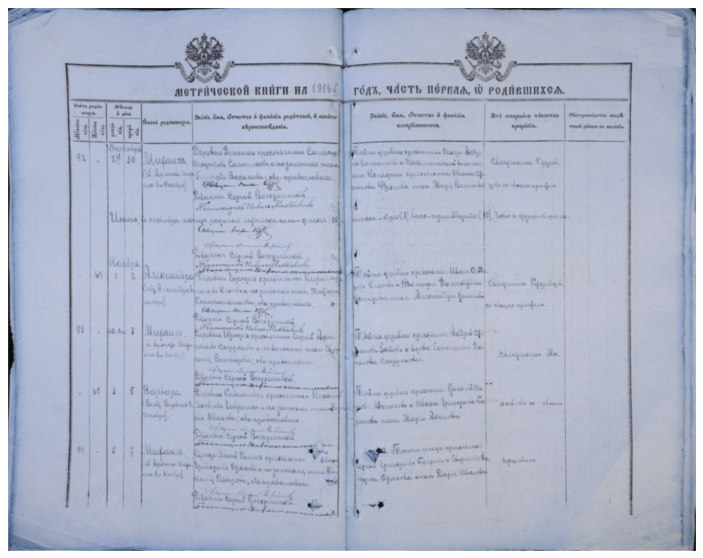

In [7]:
# read image, prepare it by resizing it to fixed height and converting it to grayscale
img1 = cv2.imread('./images/1.jpg') 
showImg(img1, cmap='gray')

In [8]:
print(img1.ndim)
print(img1.shape)

3
(3398, 4305, 3)


In [9]:
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
print(img2.shape)

(3398, 4305)


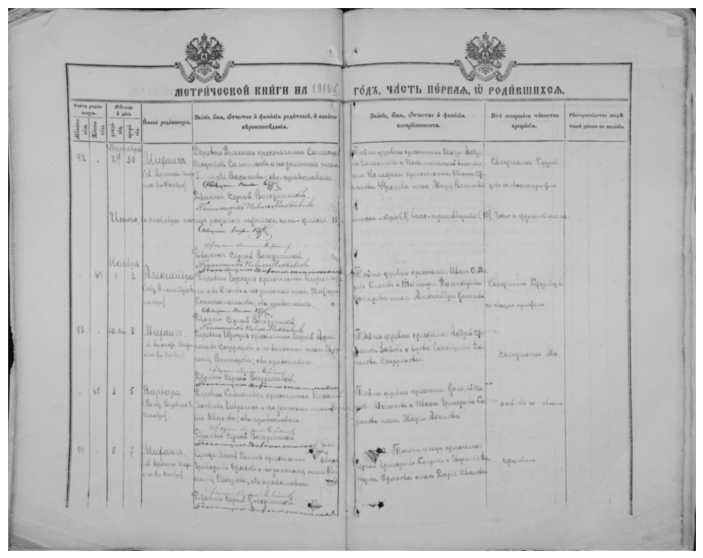

In [10]:
showImg(img2, cmap='gray')

In [11]:
type(img2)

numpy.ndarray

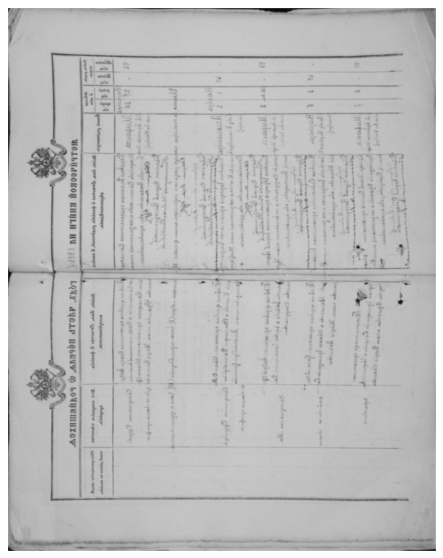

In [12]:
img3 = np.transpose(img2)
showImg(img3, cmap='gray')

In [13]:
img = np.arange(16).reshape((4,4))
img

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [14]:
showImg(img, cmap='gray')

In [17]:
def createKernel(kernelSize, sigma, theta):
    """create anisotropic filter kernel according to given parameters.
    Анизотропная диффузия Перона и Малика?"""
    assert kernelSize % 2 # must be odd size
    halfSize = kernelSize // 2

    kernel = np.zeros([kernelSize, kernelSize])
    sigmaX = sigma
    sigmaY = sigma * theta

    for i in range(kernelSize):
        for j in range(kernelSize):
            x = i - halfSize
            y = j - halfSize

            expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
            xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
            yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)

            kernel[i, j] = (xTerm + yTerm) * expTerm

    kernel = kernel / np.sum(kernel)
    return kernel

In [18]:
kernelSize=9
sigma=4
theta=1.5
#25, 0.8, 3.5

In [19]:
imgFiltered1 = cv2.filter2D(img3, -1, createKernel(kernelSize, sigma, theta), borderType=cv2.BORDER_REPLICATE)
showImg(imgFiltered1, cmap='gray')

In [20]:
def applySummFunctin(img):
    res = np.sum(img, axis = 0)    #  summ elements in columns
    return res

In [21]:
def normalize(img):
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s>0 else img
    return img
img4 = normalize(imgFiltered1)

In [22]:
(m, s) = cv2.meanStdDev(imgFiltered1)
m[0][0]

184.19397179047044

In [23]:
summ = applySummFunctin(img4)
print(summ.ndim)
print(summ.shape)

1
(3398,)


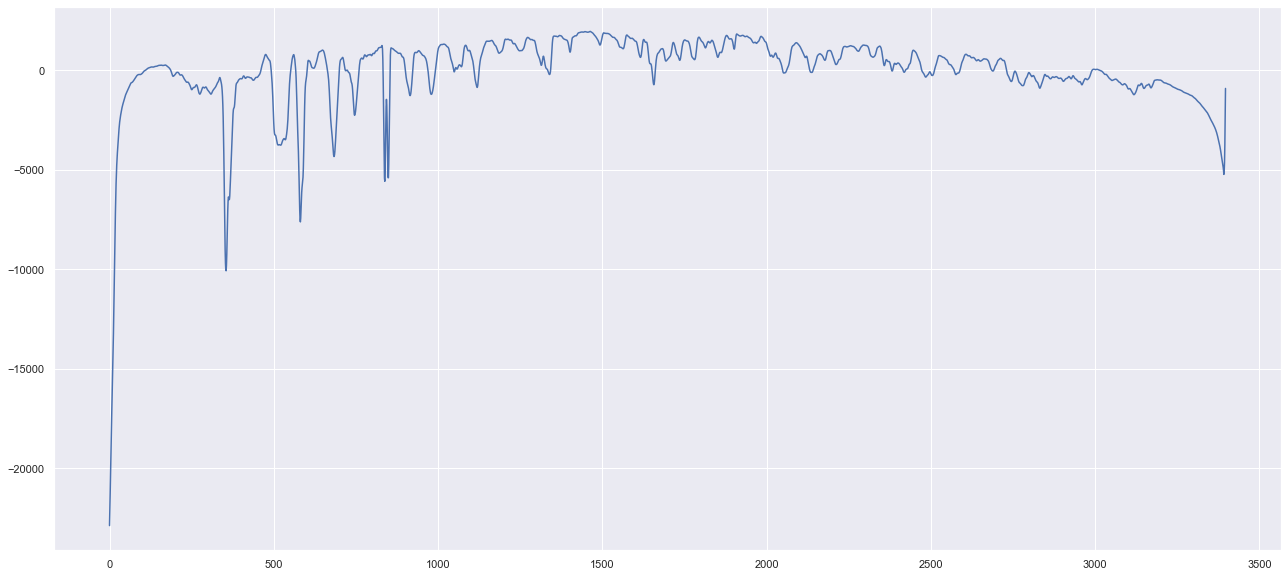

In [24]:
plt.plot(summ)
plt.show()

In [25]:
def smooth(x, window_len=11, window='hanning'):
#     if x.ndim != 1:
#         raise ValueError("smooth only accepts 1 dimension arrays.") 
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.") 
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'") 
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    return y

In [26]:
windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
smoothed = smooth(summ, 35)
plt.plot(smoothed)
plt.show()

In [27]:
from scipy.signal import argrelmin
mins = argrelmin(smoothed, order=2)
arr_mins = np.array(mins)

In [28]:
plt.plot(smoothed)
plt.plot(arr_mins, smoothed[arr_mins], "x")
plt.show()

In [29]:
img4.shape

(4305, 3398)

In [30]:
type(arr_mins[0][0])

numpy.int64

In [73]:
def crop_text_to_lines(text, blanks):
    x1 = 0
    y = 0
    lines = []
    for i, blank in enumerate(blanks):
        x2 = blank
        #print("x1=", x1, ", x2=", x2, ", Diff= ", x2-x1)
        line = text[:, x1:x2]
        lines.append(line)
        x1 = blank
    return lines
    

In [84]:
def display_lines(lines_arr, orient='vertical'):
    plt.figure(figsize=(30, 30))
    if not orient in ['vertical', 'horizontal']:
        raise ValueError("Orientation is on of 'vertical', 'horizontal', defaul = 'vertical'") 
    if orient == 'vertical': 
        for i, l in enumerate(lines_arr):
            line = l
            plt.subplot(2, 10, i+1)  # A grid of 2 rows x 10 columns
            plt.axis('off')
            plt.title("Line #{0}".format(i))
            _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    else:
            for i, l in enumerate(lines_arr):
                line = l
                plt.subplot(40, 1, i+1)  # A grid of 40 rows x 1 columns
                plt.axis('off')
                plt.title("Line #{0}".format(i))
                _ = plt.imshow(line, cmap='gray', interpolation = 'bicubic')
                plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    

In [85]:
found_lines = crop_text_to_lines(img3, arr_mins[0])

In [86]:
found_lines[2]

array([[129, 137, 141, ..., 128, 114, 118],
       [139, 141, 139, ..., 114, 122, 135],
       [147, 150, 139, ..., 128, 123, 131],
       ...,
       [132, 137, 133, ..., 102, 105, 101],
       [125, 133, 129, ..., 104, 100, 104],
       [128, 129, 134, ...,  97,  95,  99]], dtype=uint8)

In [87]:
sess = tf.compat.v1.Session()
found_lines_arr = []
with sess.as_default():
    for i in range(len(found_lines)):
        found_lines_arr.append(tf.expand_dims(found_lines[i], -1).numpy())

ValueError: num must be 1 <= num <= 20, not 21

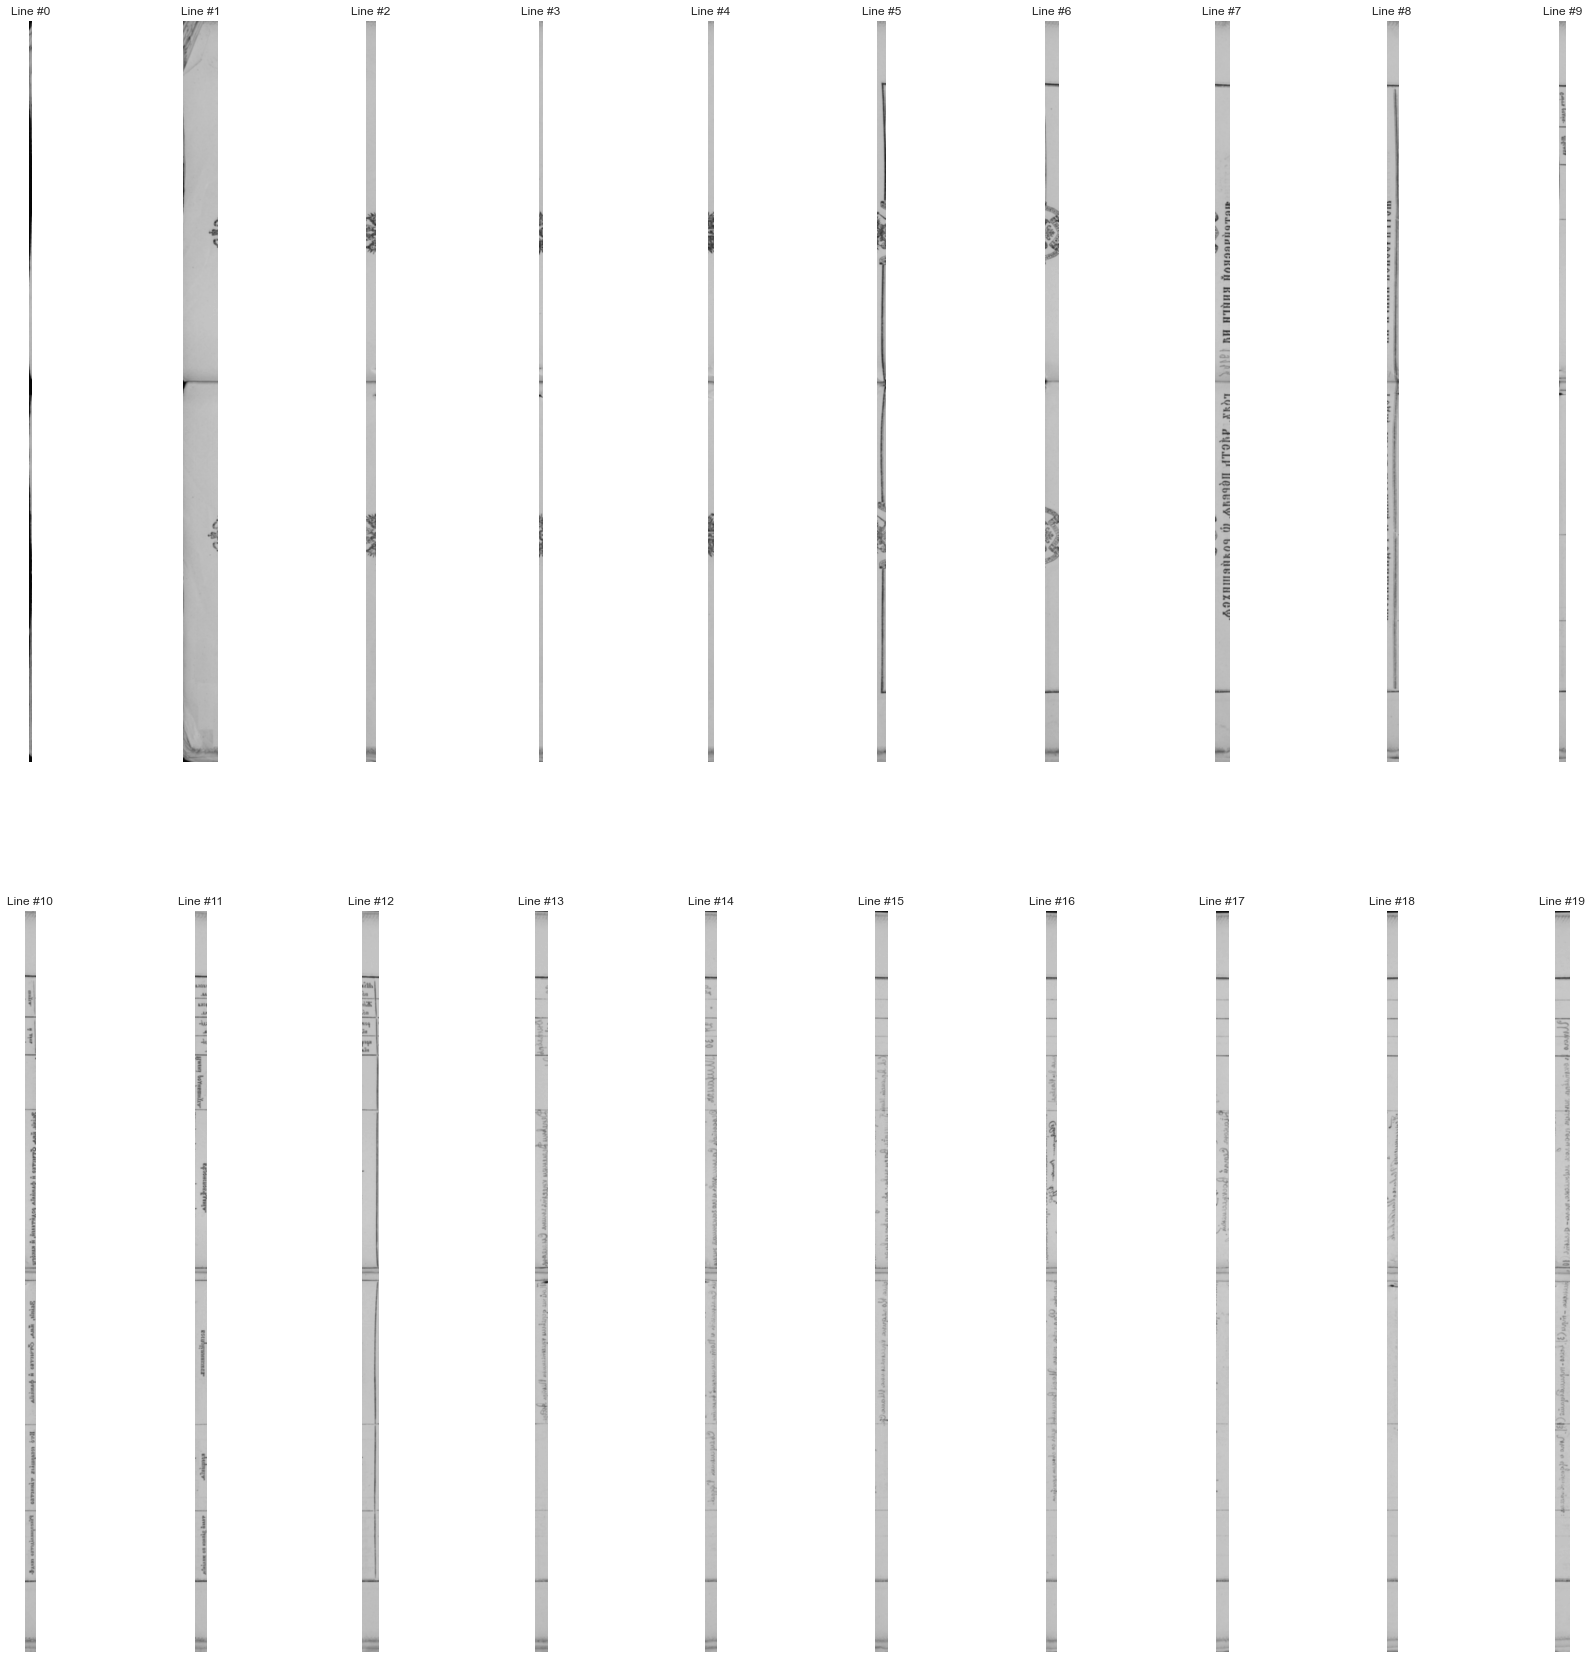

In [88]:
display_lines(found_lines)

In [89]:
def transpose_lines(lines):
    res = []
    for l in lines:
        line = np.transpose(l)
        res.append(line)
    return res
    

In [90]:
res_lines = transpose_lines(found_lines)
display_lines(res_lines, 'horizontal')

ValueError: num must be 1 <= num <= 40, not 41

## Text #3

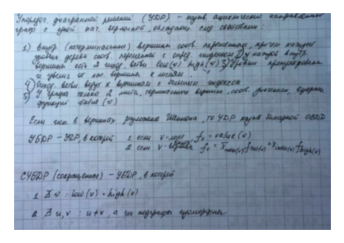

In [33]:
# read image, prepare it by resizing it to fixed height and converting it to grayscale
img3_1 = cv2.imread('../input/Text3.png') 
showImg(img3_1, cmap='gray')

In [34]:
img3_1.shape

(548, 802, 3)

In [35]:
img3_2 = cv2.cvtColor(img3_1, cv2.COLOR_BGR2GRAY)
img3_3 = np.transpose(img3_2)
k = createKernel(kernelSize, sigma, theta)
imgFiltered3 = cv2.filter2D(img3_3, -1, k, borderType=cv2.BORDER_REPLICATE)
img3_4 = normalize(imgFiltered3)
summ3 = applySummFunctin(img3_4)
smoothed3 = smooth(summ3, 35)
mins3 = argrelmin(smoothed3, order=2)
arr_mins3 = np.array(mins3)
found_lines3 = crop_text_to_lines(img3_3, arr_mins3[0])
res_lines3 = transpose_lines(found_lines3)
display_lines(res_lines3, 'horizontal')

x1= 0 , x2= 1 , Diff=  1
x1= 1 , x2= 33 , Diff=  32
x1= 33 , x2= 59 , Diff=  26
x1= 59 , x2= 104 , Diff=  45
x1= 104 , x2= 128 , Diff=  24
x1= 128 , x2= 149 , Diff=  21
x1= 149 , x2= 218 , Diff=  69
x1= 218 , x2= 245 , Diff=  27
x1= 245 , x2= 287 , Diff=  42
x1= 287 , x2= 336 , Diff=  49
x1= 336 , x2= 359 , Diff=  23
x1= 359 , x2= 429 , Diff=  70
x1= 429 , x2= 478 , Diff=  49
x1= 478 , x2= 524 , Diff=  46
x1= 524 , x2= 556 , Diff=  32
x1= 556 , x2= 572 , Diff=  16


# Method #2. (Does not work)   
Finding contours and combine then into lines.

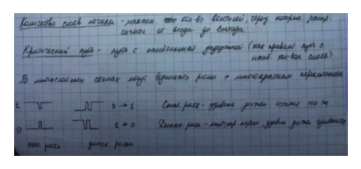

In [36]:
img2 = cv2.imread('../input/Text2.png') 
showImg(img2, cmap='gray')

In [37]:
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

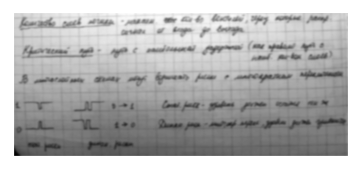

In [38]:
# apply filter kernel
kernel = createKernel(kernelSize, sigma, theta)
# The function applies an arbitrary linear filter to an image.
# int ddepth (=-1) - desired depth of the destination image
# anchor - indicates the relative position of a filtered point within the kernel; 
# default value (-1,-1) means that the anchor is at the kernel center.
# borderType - pixel extrapolation method:  
# cv2.BORDER_REPLICATE -  The row or column at the very edge of the original is replicated to the extra border.
imgFiltered2 = cv2.filter2D(img2, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
showImg(imgFiltered2, cmap='gray')

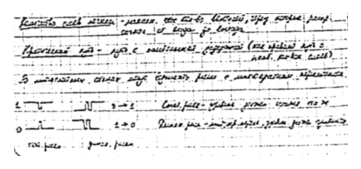

In [39]:
# threshold - If pixel value is greater than a threshold value, it is assigned one value, else it is assigned another value 
# Returns: threshold value computed, destination image
# adaptiveThreshold(src, dst, maxValue, adaptiveMethod, thresholdType, blockSize (always odd!), C)
imgThres = cv2.adaptiveThreshold(imgFiltered2, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 2) # or cv2.THRESH_BINARY+cv2.THRESH_OTSU
showImg(imgThres, cmap='gray')

In [40]:
(components, hierarchy) = cv2.findContours(imgThres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) # RETR_EXTERNAL or RETR_LIST
len(components)

1673

In [41]:
# showImg(cv2.drawContours(img2, components, -1, (255,0,0), 3, cv2.LINE_AA, hierarchy, 1 ), cmap='gray')

In [42]:
res = []
minArea = 100
for c in components:
    # skip small word candidates
    if cv2.contourArea(c) < minArea:
        continue
    # append bounding box and image of word to result list
    currBox = cv2.boundingRect(c) # returns (x, y, w, h)
    (x, y, w, h) = currBox
    currImg = img1[y:y+h, x:x+w]
    res.append((currBox, currImg))

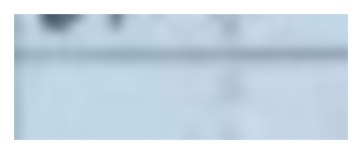

In [43]:
sns.set(rc={'figure.figsize' : (6, 3)})
(x1, y1, w1, h1) = res[8][0]
showImg(img1[y1:y1+h1, x1:x1+w1], cmap='gray')

In [44]:
len(res)

131

In [45]:
def prepareTextImg(img):
    "convert given image to grayscale image (if needed) and resize to desired height"
    assert img.ndim in (2, 3)
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [46]:
def lineSegmentation(img, kernelSize=25, sigma=11, theta=7):
    img_tmp = np.transpose(prepareTextImg(img))
    k = createKernel(kernelSize, sigma, theta)
    imgFiltered = cv2.filter2D(img_tmp, -1, k, borderType=cv2.BORDER_REPLICATE)
#     imgFiltered = cv2.adaptiveThreshold(imgFiltered2, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 2)
    img_tmp1 = normalize(imgFiltered)
    summ_pix = np.sum(img_tmp1, axis = 0)    #  summ elements in columns
    smoothed = smooth(summ_pix, 35)
    mins = np.array(argrelmin(smoothed, order=2))
    found_lines = transpose_lines(crop_text_to_lines(img_tmp, mins[0]))
    return found_lines